In [1]:
import pandas as pd
import numpy as np
import json
import uuid
import openai
import time
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time

Processing babbage-002...
Processing davinci-002...
Processing gpt-35-turbo...
Processing gpt4o...
Processing o1-mini...
Processing o1_re=low...
Processing llama3d2-1b...
Processing llama3d2-3b...
Processing llama3d2-11b...
Processing llama3d2-90b...
Processing llama3d1-405b...
Processing DK-R1-Dist-Qwen-1.5B...
Processing DK-R1-Dist-Qwen-7B...
Processing DK-R1-Dist-Qwen-14B...
Processing DK-R1-Dist-Qwen-32B...
Creating logistic curves plot for level_diff = 0, dup_threshold = 100


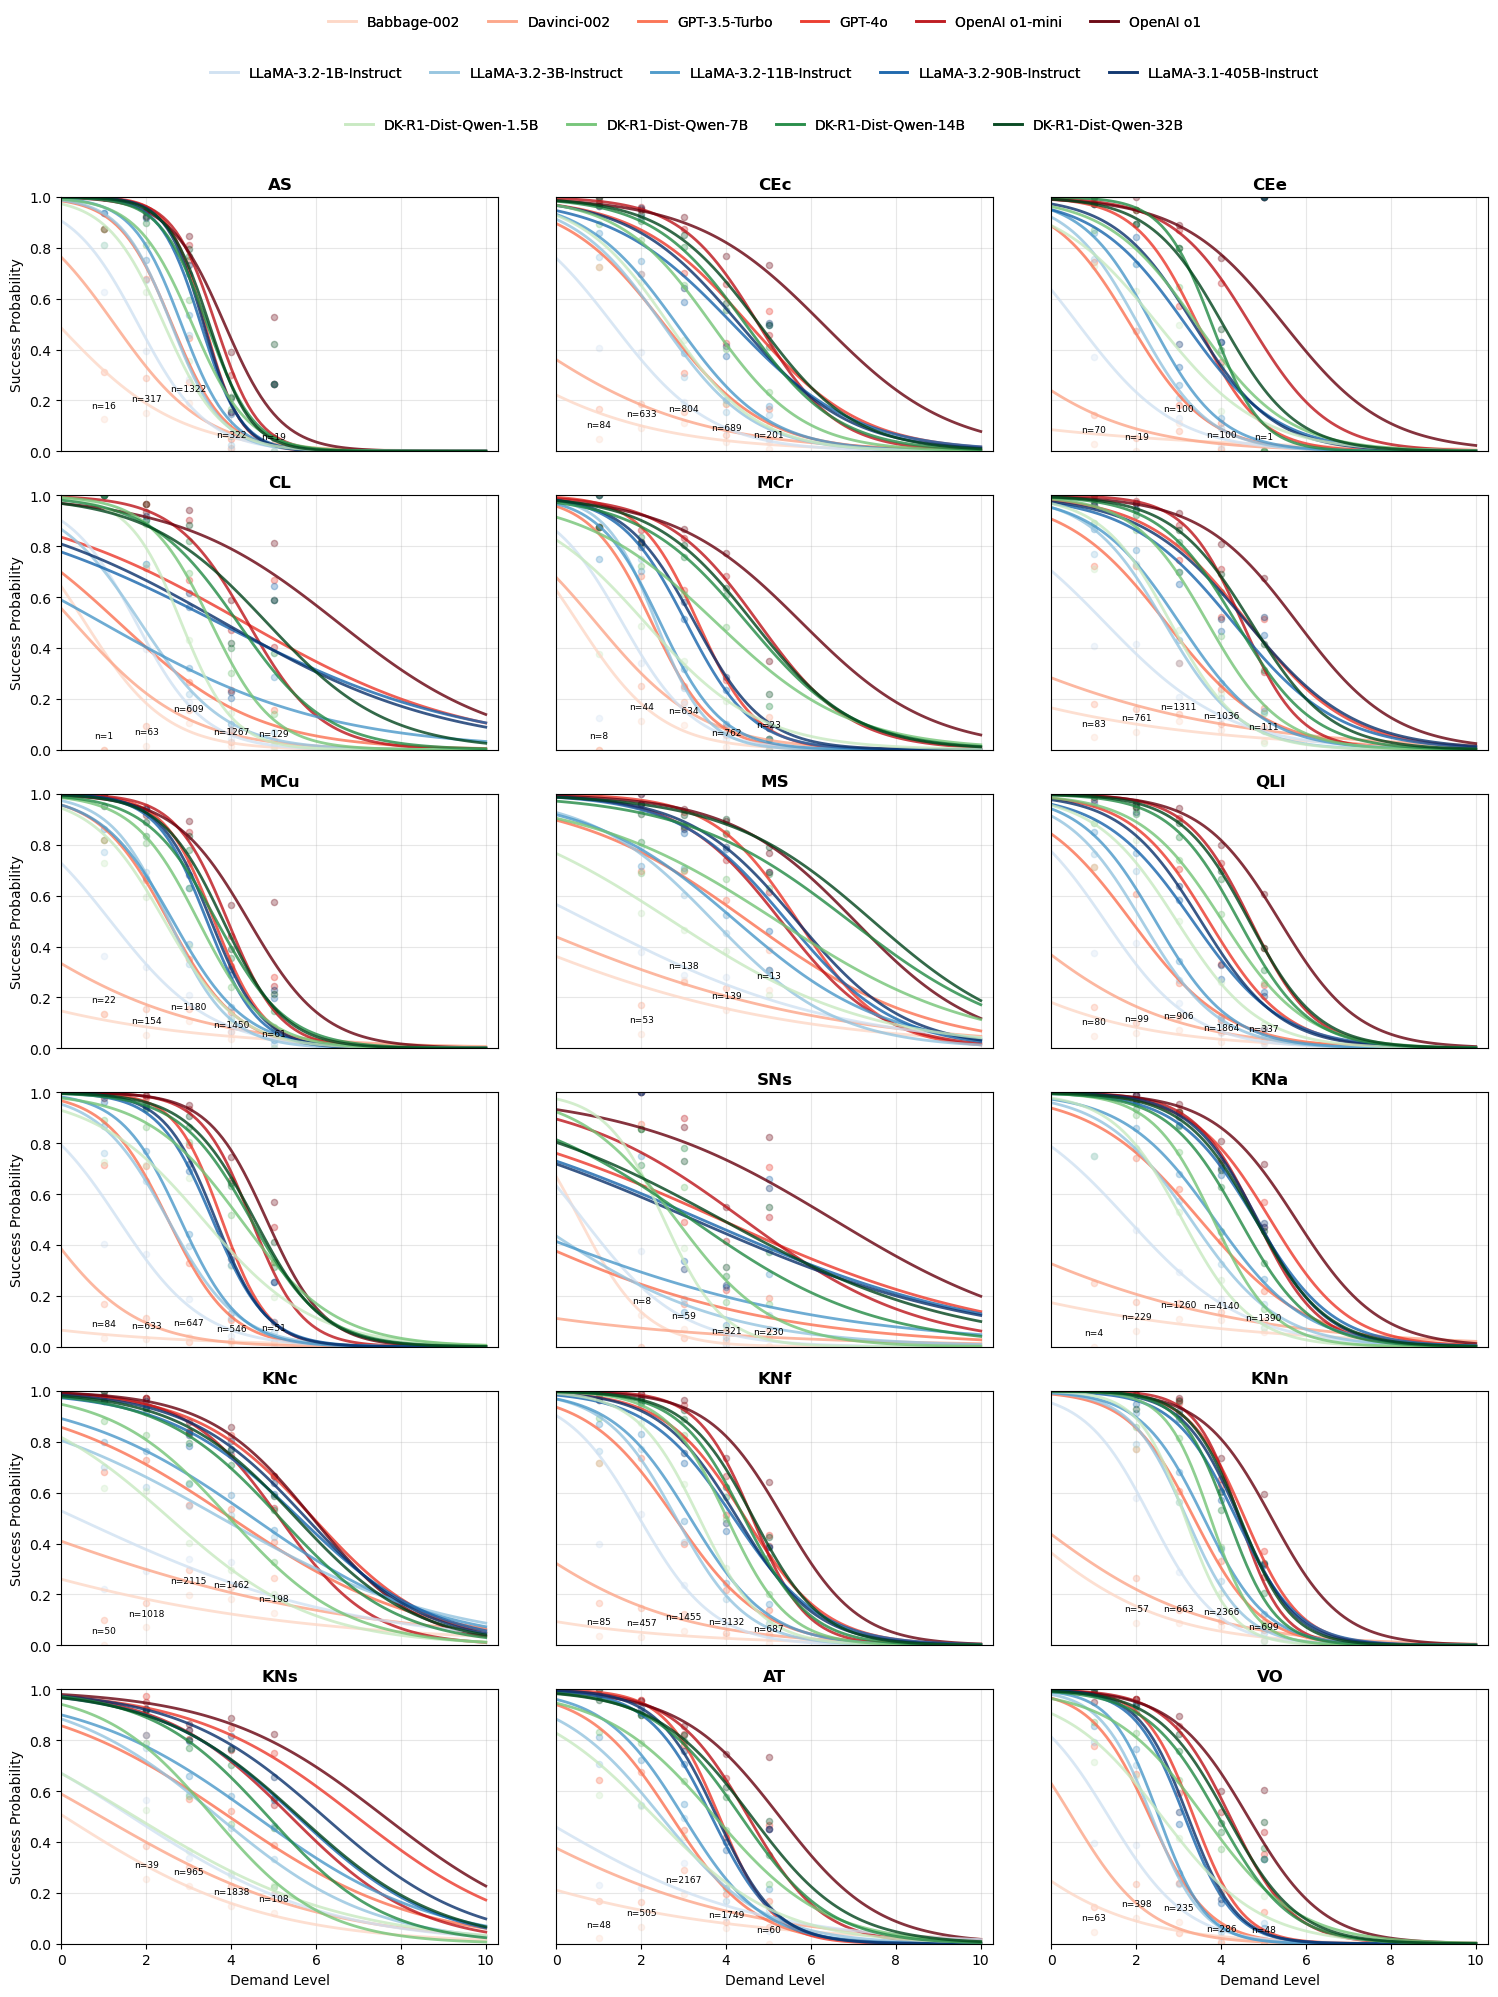

Creating radar plot for level_diff = 0, dup_threshold = 100


In [11]:
"""
GENERATE THE SCCs
"""
# -------------------------------
# Model Groups and Name Mapping
# -------------------------------

# Define the color intensity for each LLM family from light to dark
gpt_o1_models = [
    ('babbage-002', 0.16),
    ('davinci-002', 0.32),
    ('gpt-35-turbo', 0.48),
    ('gpt4o', 0.64),
    ('o1-mini', 0.80),
    ('o1_re=low', 1.0)
]

llama_models = [
    ('llama3d2-1b', 0.2),
    ('llama3d2-3b', 0.4),
    ('llama3d2-11b', 0.6),
    ('llama3d2-90b', 0.8),
    ('llama3d1-405b', 1.0)
]

ds_r1_models = [
    ('DK-R1-Dist-Qwen-1.5B', 0.25),
    ('DK-R1-Dist-Qwen-7B', 0.50),
    ('DK-R1-Dist-Qwen-14B', 0.75),
    ('DK-R1-Dist-Qwen-32B', 1.0)
]

# Standardise the names
name_mapping = {
    'babbage-002': 'Babbage-002',
    'davinci-002': 'Davinci-002',
    'gpt-35-turbo': 'GPT-3.5-Turbo',
    'gpt4o': 'GPT-4o',
    'o1-mini': 'OpenAI o1-mini',
    'o1_re=low': 'OpenAI o1',
    'llama3d2-1b': 'LLaMA-3.2-1B-Instruct',
    'llama3d2-3b': 'LLaMA-3.2-3B-Instruct',
    'llama3d2-11b': 'LLaMA-3.2-11B-Instruct',
    'llama3d2-90b': 'LLaMA-3.2-90B-Instruct',
    'llama3d1-405b': 'LLaMA-3.1-405B-Instruct',
    'DK-R1-Dist-Qwen-1.5B': 'DK-R1-Dist-Qwen-1.5B',
    'DK-R1-Dist-Qwen-7B': 'DK-R1-Dist-Qwen-7B',
    'DK-R1-Dist-Qwen-14B': 'DK-R1-Dist-Qwen-14B',
    'DK-R1-Dist-Qwen-32B': 'DK-R1-Dist-Qwen-32B'
}

# -------------------------------------------
# Compute Sample Weights with Synthetic Anchor Points
# -------------------------------------------
def compute_sample_weights_with_anchor(X_feature, y_feature, dup_threshold):
    """
    Computes sample weights for each instance in X_feature based on its bin (levels 1–5)
    using real-valued targets (without rounding to an integer).

    For each bin (levels 1–5):
        weight_factor = (target as a real number) / (original count in that bin)
    
    - For bins with count >= dup_threshold, the target is set to the maximum eligible count.
    - For bins with count below dup_threshold, the target is computed proportionally so that 
      its share of the overall target reflects its share in the original data.

    A single synthetic anchor point is added with x=20 and y=0.
    Its weight is set equal to the sum of the real-valued targets.

    The function prints the final weight factor for each bin and returns:
       X_train: augmented feature array (original points + anchor)
       y_train: corresponding labels (original labels + 0 for anchor)
       combined_weights: sample weights for each row
    """
    # Ensure X_feature is 2D
    if X_feature.ndim == 1:
        X_feature = X_feature.reshape(-1, 1)
    
    # Define bins (levels 1 through 5) and count instances per bin
    levels = [1, 2, 3, 4, 5]
    counts = {level: np.sum(X_feature.flatten() == level) for level in levels}
    total_original = sum(counts.values())
    
    # Determine eligible bins (count >= dup_threshold)
    eligible_levels = [level for level in levels if counts[level] >= dup_threshold]
    if eligible_levels:
        max_count = max(counts[level] for level in eligible_levels)
    else:
        max_count = max(counts.values())
    
    # Set targets: eligible bins get target = max_count (as float);
    # ineligible bins are computed proportionally.
    targets = {}
    for level in levels:
        if counts[level] >= dup_threshold:
            targets[level] = float(max_count)
        else:
            targets[level] = None  # placeholder

    ineligible_levels = [level for level in levels if targets[level] is None]
    E = sum(targets[level] for level in levels if targets[level] is not None)
    sum_ineligible = sum(counts[level] for level in ineligible_levels)
    
    if sum_ineligible > 0:
        T = E / (1 - (sum_ineligible / total_original))
    else:
        T = E
    for level in ineligible_levels:
        targets[level] = (counts[level] / total_original) * T
    
    # Compute sample weights for each instance in X_feature
    sample_weights = np.zeros(X_feature.shape[0], dtype=float)
    for level in levels:
        mask = (X_feature.flatten() == level)
        count_level = counts[level]
        if count_level > 0:
            weight_factor = targets[level] / count_level
            sample_weights[mask] = weight_factor

    # Print final weight factors per bin for this dimension

    #print("Final weight factors per bin for this dimension:")
    for level in levels:
        if counts[level] > 0:
            weight_factor = targets[level] / counts[level]
            #print(f"  Level {level}: original count = {counts[level]}, target = {targets[level]:.3f}, weight factor = {weight_factor:.3f}")
        else:
            #print(f"  Level {level}: no instances.")
            pass

    # Create a single synthetic anchor point with full precision weight
    total_target = sum(targets[level] for level in levels)
    X_anchor = np.array([[20]])
    y_anchor = np.array([0])
    anchor_weight = total_target  # use full real-valued total target as weight
    
    # Combine the original data and the anchor point
    X_train = np.vstack([X_feature, X_anchor])
    y_train = np.concatenate([y_feature, y_anchor])
    combined_weights = np.concatenate([sample_weights, [anchor_weight]])
    
    return X_train, y_train, combined_weights

# -------------------------------
# Part 1: Logistic Curves Plotting
# -------------------------------
def plot_combined_logistic_scc(models_data, unguessability_threshold=75, level_diff=0, dup_threshold=100):
    """
    Plot logistic curves for each feature across models.
    Uses sample weighting (with dup_threshold) for bins (levels 1–5) and a synthetic anchor point at level 20.
    Also prints a sanity check: the number of instances for all levels (1,2,3,4,5,20)
    for each dimension used to make the plot.
    """
    # Determine feature names.
    first_model = list(models_data.keys())[0]
    X_first = models_data[first_model][0]
    desired_order = [
        "AS", "CEc", "CEe", "CL", "MCr", "MCt", "MCu", "MS",
        "QLl", "QLq", "SNs", "KNa", "KNc", "KNf", "KNn", "KNs",
        "AT", "VO"
    ]
    feature_names = [name for name in desired_order if name in X_first.columns]
    n_features = len(feature_names)
    
    n_rows = (n_features + 2) // 3
    n_cols = min(3, n_features)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4.3 * n_rows))
    axs = np.array(axs) if n_rows > 1 else np.array([axs])
    plt.tight_layout(rect=[0, 0, 1, 0.7])
    
    x_values = np.linspace(0, 10, 101)
    score_points = np.array([1, 2, 3, 4, 5])
    
    gpt_legend, llama_legend, dk_legend = {}, {}, {}
    
    for idx, feature in enumerate(feature_names):
        row, col = idx // 3, idx % 3
        ax = axs[row, col]
        for model_name, (X, y) in models_data.items():
            # Determine group and color.
            if any(model_name == m[0] for m in gpt_o1_models):
                base_color = 'red'
                alpha = dict(gpt_o1_models)[model_name]
                group = 'GPT/o1'
            elif any(model_name == m[0] for m in llama_models):
                base_color = 'blue'
                alpha = dict(llama_models)[model_name]
                group = 'LLAMA'
            elif any(model_name == m[0] for m in ds_r1_models):
                base_color = 'green'
                alpha = dict(ds_r1_models)[model_name]
                group = 'DK'
            else:
                base_color = 'green'
                alpha = 0.5
                group = 'Other'
            
            mask = X['UG'] >= unguessability_threshold
            X_filtered = X[mask].copy()
            y_filtered = y[mask].copy()
            
            other_features = [f for f in feature_names if f != feature]
            level_mask = X_filtered[other_features].max(axis=1) <= (X_filtered[feature] + level_diff)
            X_level_filtered = X_filtered[level_mask]
            y_level_filtered = y_filtered[level_mask]
            
            if len(y_level_filtered) > 0:
                X_feature = X_level_filtered[[feature]].values
                y_feature = y_level_filtered.to_numpy()
                
                # Data augmentation using sample weighting (with a synthetic anchor point)
                X_train, y_train, sample_weights = compute_sample_weights_with_anchor(X_feature, y_feature, dup_threshold)
                
                """
                # -----------------------------
                # Sanity Check: Print instance counts for levels.
                unique_levels, counts_per_level = np.unique(X_train.flatten(), return_counts=True)
                print(f"Sanity check for model '{model_name}', dimension '{feature}':")
                for lvl, cnt in zip(unique_levels, counts_per_level):
                    print(f"   Level {int(lvl)}: {cnt} instances")
                # -----------------------------
               
                """
                lr = LogisticRegression(random_state=42, max_iter=10000)
                lr.fit(X_train, y_train, sample_weight=sample_weights)
                X_pred = x_values.reshape(-1, 1)
                predictions = lr.predict_proba(X_pred)[:, 1]
                
                if base_color == 'red':
                    color = plt.cm.Reds(alpha)
                elif base_color == 'blue':
                    color = plt.cm.Blues(alpha)
                else:
                    color = plt.cm.Greens(alpha)
                
                display_name = name_mapping.get(model_name, model_name)
                line_handle = ax.plot(x_values, predictions, '-', color=color, linewidth=2,
                                      label=display_name, alpha=0.8)[0]
                
                if group == 'GPT/o1' and display_name not in gpt_legend:
                    gpt_legend[display_name] = line_handle
                elif group == 'LLAMA' and display_name not in llama_legend:
                    llama_legend[display_name] = line_handle
                elif group == 'DK' and display_name not in dk_legend:
                    dk_legend[display_name] = line_handle
                
                for score in score_points:
                    score_mask = (X_filtered[feature] == score)
                    level_mask_score = X_filtered[other_features].max(axis=1) <= (score + level_diff)
                    combined_mask = score_mask & level_mask_score
                    if combined_mask.sum() > 0:
                        mean_response = y_filtered[combined_mask].mean()
                        ax.scatter([score], [mean_response], color=color, s=20, alpha=0.3)
                        if model_name == list(models_data.keys())[0]:
                            ax.annotate(f'n={combined_mask.sum()}',
                                        (score, mean_response),
                                        xytext=(0, 8.5),
                                        textcoords='offset points',
                                        ha='center', fontsize=6.5)
        
        ax.set_title(feature, fontweight="bold")
        if col == 0:
            ax.set_ylabel('Success Probability')
        else:
            ax.set_ylabel('')
            ax.tick_params(axis='y', left=False, labelleft=False)
        if row == n_rows - 1:
            ax.set_xlabel('Demand Level')
        else:
            ax.set_xlabel('')
            ax.tick_params(axis='x', bottom=False, labelbottom=False)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.0)
        ax.set_xlim(0, 10.3)
    
    if n_features < n_rows * n_cols:
        for idx in range(n_features, n_rows * n_cols):
            row = idx // 3
            col = idx % 3
            fig.delaxes(axs[row, col])
    
    y_gpt, y_llama, y_dk = 0.76, 0.74, 0.72
    if gpt_legend:
        gpt_leg = fig.legend(
            handles=list(gpt_legend.values()),
            labels=list(gpt_legend.keys()),
            loc='center', bbox_to_anchor=(0.5, y_gpt),
            ncol=len(gpt_legend), frameon=False)
        fig.add_artist(gpt_leg)
    if llama_legend:
        llama_leg = fig.legend(
            handles=list(llama_legend.values()),
            labels=list(llama_legend.keys()),
            loc='center', bbox_to_anchor=(0.5, y_llama),
            ncol=len(llama_legend), frameon=False)
        fig.add_artist(llama_leg)
    if dk_legend:
        dk_leg = fig.legend(
            handles=list(dk_legend.values()),
            labels=list(dk_legend.keys()),
            loc='center', bbox_to_anchor=(0.5, y_dk),
            ncol=len(dk_legend), frameon=False)
        fig.add_artist(dk_leg)
    
    plt.savefig(f"./figures/Combined_SCCs_MaxAuxDiff={level_diff}_DupThresh={dup_threshold}.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

# -------------------------------
# Data Collection
# -------------------------------
models_data = {}
model_list = [
    'babbage-002', 'davinci-002', 'gpt-35-turbo', 'gpt4o', 'o1-mini', 'o1_re=low',
    'llama3d2-1b', 'llama3d2-3b', 'llama3d2-11b', 'llama3d2-90b', 'llama3d1-405b',
    'DK-R1-Dist-Qwen-1.5B', 'DK-R1-Dist-Qwen-7B', 'DK-R1-Dist-Qwen-14B', 'DK-R1-Dist-Qwen-32B'
]

### READ the instance-level data
for model in model_list:
    print(f"Processing {model}...")
    ### IMPORTANT: Replace this with your own instance-level data (including demands and verification_final/performance)
    ### To reproduce the paper, use the instance-level data released here: https://kinds-of-intelligence-cfi.github.io/ADELE/
    df = pd.read_csv(f'./subject_data_filtered/{model}.csv') 
    X = pd.concat([df['UG'], df.iloc[:, -19:-1]], axis=1)
    X = X.apply(pd.to_numeric, errors='coerce')
    y = df['verification_final']
    nan_rows = X.isna().any(axis=1)
    X_clean = X[~nan_rows].reset_index(drop=True)
    y_clean = y[~nan_rows].reset_index(drop=True)
    models_data[model] = (X_clean, y_clean)

# -------------------------------
# Generate the SCCs
# -------------------------------
dup_threshold = 100
max_aux_diff=0

print(f"Creating logistic curves plot for level_diff = {max_aux_diff}, dup_threshold = {dup_threshold}")
plot_combined_logistic_scc(models_data, unguessability_threshold=75,
                           level_diff=max_aux_diff, dup_threshold=dup_threshold)

print(f"Creating radar plot for level_diff = {max_aux_diff}, dup_threshold = {dup_threshold}")



Processing babbage-002...
Processing davinci-002...
Processing gpt-35-turbo...
Processing gpt4o...
Processing o1-mini...
Processing o1_re=low...
Processing llama3d2-1b...
Processing llama3d2-3b...
Processing llama3d2-11b...
Processing llama3d2-90b...
Processing llama3d1-405b...
Processing DK-R1-Dist-Qwen-1.5B...
Processing DK-R1-Dist-Qwen-7B...
Processing DK-R1-Dist-Qwen-14B...
Processing DK-R1-Dist-Qwen-32B...


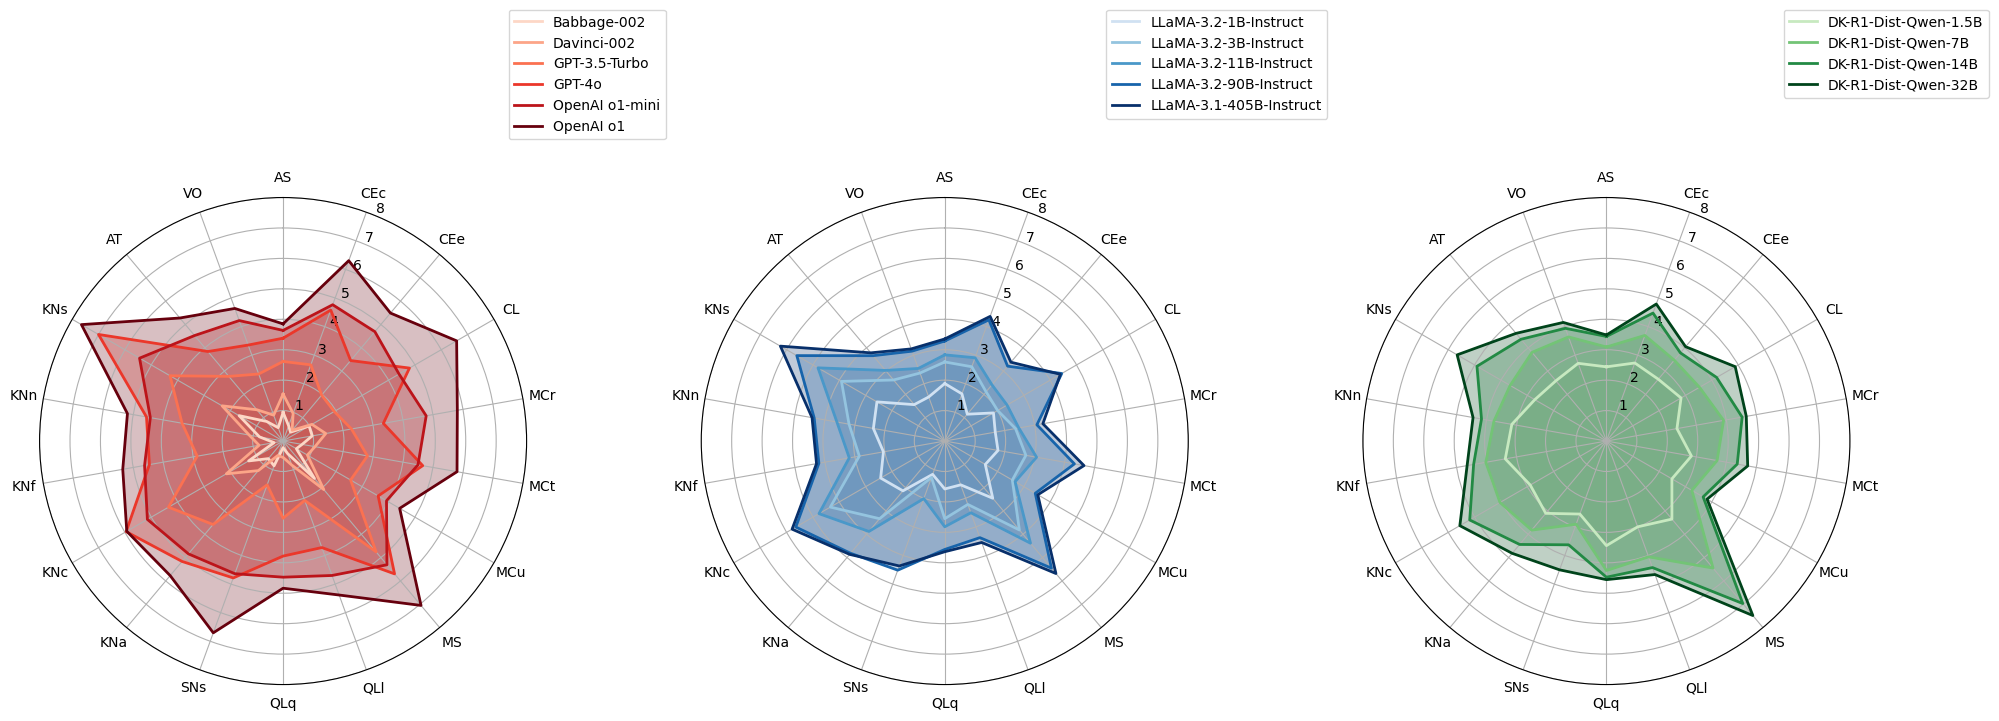

In [15]:
"""
GENERATE THE ABILITY PROFILES
"""
# -------------------------------
# Model Groups and Name Mapping
# -------------------------------

# Define the color intensity for each LLM family from light to dark
gpt_o1_models = [
    ('babbage-002', 0.16),
    ('davinci-002', 0.32),
    ('gpt-35-turbo', 0.48),
    ('gpt4o', 0.64),
    ('o1-mini', 0.80),
    ('o1_re=low', 1.0)
]

llama_models = [
    ('llama3d2-1b', 0.2),
    ('llama3d2-3b', 0.4),
    ('llama3d2-11b', 0.6),
    ('llama3d2-90b', 0.8),
    ('llama3d1-405b', 1.0)
]

ds_r1_models = [
    ('DK-R1-Dist-Qwen-1.5B', 0.25),
    ('DK-R1-Dist-Qwen-7B', 0.50),
    ('DK-R1-Dist-Qwen-14B', 0.75),
    ('DK-R1-Dist-Qwen-32B', 1.0)
]

# Standardise the names
name_mapping = {
    'babbage-002': 'Babbage-002',
    'davinci-002': 'Davinci-002',
    'gpt-35-turbo': 'GPT-3.5-Turbo',
    'gpt4o': 'GPT-4o',
    'o1-mini': 'OpenAI o1-mini',
    'o1_re=low': 'OpenAI o1',
    'llama3d2-1b': 'LLaMA-3.2-1B-Instruct',
    'llama3d2-3b': 'LLaMA-3.2-3B-Instruct',
    'llama3d2-11b': 'LLaMA-3.2-11B-Instruct',
    'llama3d2-90b': 'LLaMA-3.2-90B-Instruct',
    'llama3d1-405b': 'LLaMA-3.1-405B-Instruct',
    'DK-R1-Dist-Qwen-1.5B': 'DK-R1-Dist-Qwen-1.5B',
    'DK-R1-Dist-Qwen-7B': 'DK-R1-Dist-Qwen-7B',
    'DK-R1-Dist-Qwen-14B': 'DK-R1-Dist-Qwen-14B',
    'DK-R1-Dist-Qwen-32B': 'DK-R1-Dist-Qwen-32B'
}

# -------------------------------------------
# Data Augmentation: Sample Weighting with Synthetic Anchor
# -------------------------------------------
def compute_sample_weights_with_anchor(X_feature, y_feature, dup_threshold):
    """
    For the given feature (with values in {1,2,3,4,5}), compute sample weights for each instance
    using real-valued targets instead of duplicating rows.
    
    For each bin:
      - If the number of instances is >= dup_threshold, the target is set to the maximum eligible count (as a float).
      - Otherwise, the target is computed proportionally so that the bin’s share reflects its original proportion.
      
    The weight for each sample in a bin is:
         weight = (target as a real number) / (original count in that bin)
    
    A single synthetic anchor point is then created at level 20 with label 0.
    Its weight is equal to the sum of the targets across levels 1–5.
    
    Returns:
       X_train: augmented feature array (original points plus anchor)
       y_train: augmented target array (original labels plus 0 for the anchor)
       combined_weights: sample weights for each row
    """
    # Ensure X_feature is 2D.
    if X_feature.ndim == 1:
        X_feature = X_feature.reshape(-1, 1)
        
    # Count instances per level for levels 1–5.
    levels = [1, 2, 3, 4, 5]
    counts = {level: np.sum(X_feature.flatten() == level) for level in levels}
    total_original = sum(counts.values())
    
    # Determine eligible bins (count >= dup_threshold)
    eligible_levels = [level for level in levels if counts[level] >= dup_threshold]
    if eligible_levels:
        majority_count = max(counts[level] for level in eligible_levels)
    else:
        majority_count = max(counts.values())
    
    # Set target for each bin.
    targets = {}
    for level in levels:
        if counts[level] >= dup_threshold:
            targets[level] = float(majority_count)
        else:
            targets[level] = None  # placeholder for ineligible bins.
    
    # Compute targets for ineligible bins proportionally.
    ineligible_levels = [level for level in levels if targets[level] is None]
    E = sum(targets[level] for level in levels if targets[level] is not None)
    sum_ineligible = sum(counts[level] for level in ineligible_levels)
    if sum_ineligible > 0:
        T = E / (1 - (sum_ineligible / total_original))
    else:
        T = E
    for level in ineligible_levels:
        targets[level] = (counts[level] / total_original) * T
        
    # Compute sample weights for each instance.
    sample_weights = np.zeros(X_feature.shape[0], dtype=float)
    for level in levels:
        mask = (X_feature.flatten() == level)
        count_level = counts[level]
        if count_level > 0:
            weight_factor = targets[level] / count_level
            sample_weights[mask] = weight_factor
            
    # Print final weight factors per bin.
    #print("Final weight factors per bin:")
    for level in levels:
        if counts[level] > 0:
            weight_factor = targets[level] / counts[level]
            # print(f"  Level {level}: original count = {counts[level]}, target = {targets[level]:.3f}, weight factor = {weight_factor:.3f}")
        else:
            # print(f"  Level {level}: no instances.")
            pass
    
    # Create a single synthetic anchor point.
    total_target = sum(targets[level] for level in levels)
    X_anchor = np.full((1, 1), 20)
    y_anchor = np.zeros(1)
    anchor_weight = total_target  # full real-valued target sum as weight.
    
    # Combine original data and anchor.
    X_train = np.vstack([X_feature, X_anchor])
    y_train = np.concatenate([y_feature, y_anchor])
    combined_weights = np.concatenate([sample_weights, [anchor_weight]])
    
    return X_train, y_train, combined_weights

# --- Compute AUC for Estimated Logistic Curves ---
def compute_auc_for_logistic_curves(models_data, unguessability_threshold=75, level_diff=0,
                                    grid_min=0, grid_max=100, n_grid=10001, dup_threshold=100):
    """
    For each model and each feature (excluding 'UG'), compute the area under the estimated logistic curve.
    This AUC (a single number per feature per model) serves as the ability score in the radar plots.
    
    This version uses sample weighting with a synthetic anchor point instead of oversampling.
    
    Parameters:
      models_data : dict
          Dictionary with model names as keys and (X, y) tuples as values.
      unguessability_threshold : int
          Minimum value for the 'UG' feature.
      level_diff : int
          Maximum allowed difference between the current feature and the maximum of the other features.
      grid_min, grid_max, n_grid : float, float, int
          Defines the grid over which to compute predictions.
      dup_threshold : int
          Threshold for minimum instances in a bin to trigger sample weighting.
    
    Returns:
      auc_dict : dict
          Dictionary of the form {model_name: {feature: auc_value, ...}, ...}
      feature_names : list
          List of features (excluding 'UG') used.
    """
    auc_dict = {}
    first_model = list(models_data.keys())[0]
    X_first = models_data[first_model][0]
    feature_names = [name for name in X_first.columns if name != 'UG']
    
    x_values = np.linspace(grid_min, grid_max, n_grid)
    
    for model_name, (X, y) in models_data.items():
        auc_dict[model_name] = {}
        mask = X['UG'] >= unguessability_threshold
        X_filtered = X[mask].copy()
        y_filtered = y[mask].copy()
        
        for feature in feature_names:
            other_features = [f for f in feature_names if f != feature]
            level_mask = X_filtered[other_features].max(axis=1) <= (X_filtered[feature] + level_diff)
            X_level_filtered = X_filtered[level_mask]
            y_level_filtered = y_filtered[level_mask]
            
            if len(y_level_filtered) > 0:
                X_feature = X_level_filtered[[feature]].values
                y_feature = y_level_filtered.to_numpy()
                
                # Augment data using sample weighting with synthetic anchor.
                X_train, y_train, sample_weights = compute_sample_weights_with_anchor(X_feature, y_feature, dup_threshold)
                """
                # -----------------------------
                # Sanity Check: Print instance counts for levels.
                unique_levels, counts_per_level = np.unique(X_train.flatten(), return_counts=True)
                print(f"Sanity check for model '{model_name}', dimension '{feature}':")
                for lvl, cnt in zip(unique_levels, counts_per_level):
                    print(f"   Level {int(lvl)}: {cnt} instances")
                # -----------------------------
                """
                lr = LogisticRegression(random_state=42, max_iter=10000)
                lr.fit(X_train, y_train, sample_weight=sample_weights)
                X_pred = x_values.reshape(-1, 1)
                predictions = lr.predict_proba(X_pred)[:, 1]
                
                auc_value = np.trapz(predictions, x_values)
                auc_dict[model_name][feature] = auc_value
            else:
                auc_dict[model_name][feature] = np.nan
                
    return auc_dict, feature_names

# --- Plot Radar Plot of AUC values for Multiple Subplots ---
def plot_radar_auc_subplots(auc_dict, feature_names, title="AUCs from Logistic Curves", level_diff=0, dup_threshold=100):
    """
    Create a radar plot comparing models using the area under their estimated logistic curves.
    """
    desired_order = [
        "AS", "CEc", "CEe", "CL", "MCr", "MCt", "MCu", "MS",
        "QLl", "QLq", "SNs", "KNa", "KNc", "KNf", "KNn", "KNs",
        "AT", "VO"
    ]
    feature_names = [feat for feat in desired_order if feat in feature_names]
    N = len(feature_names)
    
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6.5), subplot_kw=dict(polar=True))
    for ax in axes:
        ax.set_theta_direction(-1)
        ax.set_theta_offset(np.pi/2)
        
    def plot_single_radar(ax, models_group, group_name):
        for model in models_group:
            display_name = name_mapping.get(model, model)
            values = [auc_dict[model][feat] for feat in feature_names]
            values = [0 if np.isnan(v) else v for v in values]
            values += values[:1]
            
            if group_name == 'gpt_o1':
                alpha = dict(gpt_o1_models)[model]
                base_color = plt.cm.Reds(alpha)
            elif group_name == 'llama':
                alpha = dict(llama_models)[model]
                base_color = plt.cm.Blues(alpha)
            elif group_name == 'ds_r1':
                alpha = dict(ds_r1_models)[model]
                base_color = plt.cm.Greens(alpha)
            
            ax.plot(angles, values, label=display_name, color=base_color, linewidth=2)
            ax.fill(angles, values, alpha=0.25, color=base_color)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(feature_names, fontsize=10)
        ax.set_ylim(0, 8)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.4))
    
    plot_single_radar(axes[0], [model[0] for model in gpt_o1_models], 'gpt_o1')
    plot_single_radar(axes[1], [model[0] for model in llama_models], 'llama')
    plot_single_radar(axes[2], [model[0] for model in ds_r1_models], 'ds_r1')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(f"./figures/capability_radar_plot_MaxAuxDiff={level_diff}_DubThresh={dup_threshold}.pdf", bbox_inches='tight')
    plt.show()

# --- Data Collection (Same as before) ---
models_data = {}
model_list = [
    'babbage-002', 'davinci-002', 'gpt-35-turbo', 'gpt4o', 'o1-mini', 'o1_re=low',
    'llama3d2-1b', 'llama3d2-3b', 'llama3d2-11b', 'llama3d2-90b', 'llama3d1-405b',
    'DK-R1-Dist-Qwen-1.5B', 'DK-R1-Dist-Qwen-7B', 'DK-R1-Dist-Qwen-14B', 'DK-R1-Dist-Qwen-32B'
]

### READ the instance-level datas
for model in model_list:
    print(f"Processing {model}...")
    ### IMPORTANT: Replace this with your own instance-level data (including demands and verification_final/performance)
    ### To reproduce the paper, use the instance-level data released here: https://kinds-of-intelligence-cfi.github.io/ADELE/
    df = pd.read_csv(f'./subject_data_filtered/{model}.csv')
    X = pd.concat([df['UG'], df.iloc[:, -19:-1]], axis=1)
    X = X.apply(pd.to_numeric, errors='coerce')
    y = df['verification_final']
    
    nan_rows = X.isna().any(axis=1)
    X_clean = X[~nan_rows].reset_index(drop=True)
    y_clean = y[~nan_rows].reset_index(drop=True)
    
    models_data[model] = (X_clean, y_clean)

# --- Compute AUC values for each model and feature ---
max_aux_diff = 0
dup_threshold = 100

auc_dict, feature_names = compute_auc_for_logistic_curves(
    models_data, unguessability_threshold=75, level_diff=max_aux_diff,
    dup_threshold=dup_threshold
)

plot_radar_auc_subplots(auc_dict, feature_names, level_diff=max_aux_diff, dup_threshold=dup_threshold)

# --- Build and Save CSV of Ability Scores ---
ability_profiles_df = pd.DataFrame.from_dict(auc_dict, orient='index')
desired_order = [
    "AS", "CEc", "CEe", "CL", "MCr", "MCt", "MCu", "MS",
    "QLl", "QLq", "SNs", "KNa", "KNc", "KNf", "KNn", "KNs",
    "AT", "VO"
]
cols_ordered = [col for col in desired_order if col in ability_profiles_df.columns]
ability_profiles_df = ability_profiles_df[cols_ordered]

ability_profiles_df.index = [name_mapping.get(model, model) for model in ability_profiles_df.index]
ability_profiles_df.to_csv(f"./ability_profiles_MaxAuxDiff={max_aux_diff}_DupThresh={dup_threshold}.csv")
